# Naive Bayes Implementation

The main ideia of this code is to implement the Naive Bayes algorithm. Since only images are given, it is used a pretrained googlenet with the last layer removed (replaced by the identity matrix). The last layer corresponds to the layer that performs classification. The features extracted from the google net are the ones going into the Naive Bayes algorithm.

In this case, the underlying distribution of the data (likelihood) was chosen to be gaussian, the prior is computed based on the ammount of samples for each class. Finally, with the Bayes Theorem the posterior can be computed and decisions can be made based on it.

Dependencies

In [1]:
import numpy as np
import pandas as pd

import os
#import random
#from operator import itemgetter
import copy
import time
from datetime import datetime

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
#import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from PIL import Image

import glob

from tqdm import tqdm

import seaborn as sns

import pickle

from torch.utils.tensorboard import SummaryWriter


#import warnings
#warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device being used : " + str(device))

Device being used : cuda:0


Define paths and categories (labels)


In [2]:
path_dataset = "flowers"
path_split = "tvt_flowers"
path_models = "models"
path_data_plots = "data_plots"
path_plots = "plots"
path_models = "models"

training_data_path = os.path.join(path_split,"train")
validation_data_path = os.path.join(path_split,"val")
testing_data_path =os.path.join(path_split,"test")

categories=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Import the training data produced by the "data_preparation.ipynb"

In [3]:
channel_means = torch.Tensor([0.4590, 0.4201, 0.3005])
channel_std = torch.Tensor([0.2940, 0.2635, 0.2863])

transformation = transforms.Compose([transforms.Resize((220, 220)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((channel_means[0].item(), channel_means[1].item(), channel_means[2].item()), 
                                                                    (channel_std[0].item(), channel_std[1].item(), channel_std[2].item()))])
                                                                                               

training_ds = ImageFolder(training_data_path, transform = transformation)
val_ds = ImageFolder(validation_data_path, transform = transformation)
test_ds = ImageFolder(testing_data_path, transform = transformation)

Setting up the data

In [4]:
print("Changing data to numpy")
training_ds, discard = train_test_split(training_ds, test_size=1)
training_ds.append(discard[0])
print("Finished copying training data augmented")
val_ds, discard = train_test_split(val_ds, test_size=1)
val_ds.append(discard[0])
print("Finished copying validation data")

#Merging both training and validation since validation is not used for the Naive Bayes, therefore, we can have more training data
training_ds = training_ds + val_ds

Changing data to numpy
Finished copying training data augmented
Finished copying validation data


In [5]:
bs = 32 #batch size
nw = 4 #number of workers

loaders = {
    'train': DataLoader(training_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test': DataLoader(test_ds, batch_size=bs, num_workers=nw, pin_memory=True)
}

In [7]:
feature_extractor = torchvision.models.googlenet(pretrained=True)
feature_extractor.fc = nn.Identity()

feature_extractor = feature_extractor.to(device)
x_train = []
y_train = []
x_test = []
y_test = []

print("Extracting features for the training data")

for inputs, labels in tqdm(loaders['train']):

    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = feature_extractor(inputs)

    for tensor in outputs:
        x_train.append(tensor)
    for tensor in labels:
        y_train.append(tensor)

print("Extracting features for the testing data")

for inputs, labels in tqdm(loaders['test']):
    
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = feature_extractor(inputs)

    for tensor in outputs:
        x_test.append(tensor)
    for tensor in labels:
        y_test.append(tensor)


Extracting features for the training data


100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


Extracting features for the testing data


100%|██████████| 28/28 [00:03<00:00,  8.40it/s]


Putting data from a list into a tensor, them converting to a numpy array

In [8]:
x_train = torch.stack(x_train)
y_train = torch.stack(y_train)
x_test = torch.stack(x_test)
y_test = torch.stack(y_test)

In [9]:
x_train_np = x_train.cpu().numpy()
y_train_np = y_train.cpu().numpy()
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

Apply Naive Bayes

In [10]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train_np, y_train_np)

# Predicting the Test set results
y_pred = classifier.predict(x_test_np)
ac = accuracy_score(y_test,y_pred)

Check accuracy on test data

In [11]:
print("Accuracy : {:.2f}%".format(ac*100))

Accuracy : 31.11%


<Figure size 432x288 with 0 Axes>

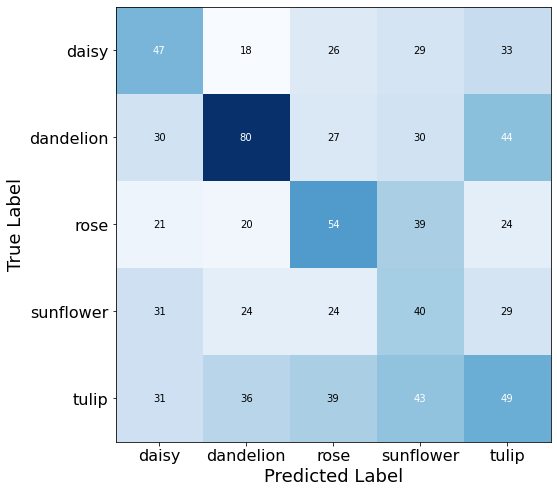

In [12]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=16)
plt.yticks(range(len(categories)), categories, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()